### Reconstructing the past: estimating solar radio flux F10.7 from sunspot records  
#### Team members: Areeba Hashmi, Hifza Ijaz, Denis Boborukhin, Skoltech, 2025

In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# read from the files
radio_flux_data = np.loadtxt('data/Radio_flux_monthly_mean.txt')
radio_year = radio_flux_data[:, 0].astype(int)
radio_month = radio_flux_data[:, 1].astype(int)
radio_flux = radio_flux_data[:, 2]

sunspot_data = np.loadtxt('data/Sunspot_number_monthly_mean.txt')
sunspot_year = sunspot_data[:, 0].astype(int)
sunspot_month = sunspot_data[:, 1].astype(int)
sunspot_number = sunspot_data[:, 2]

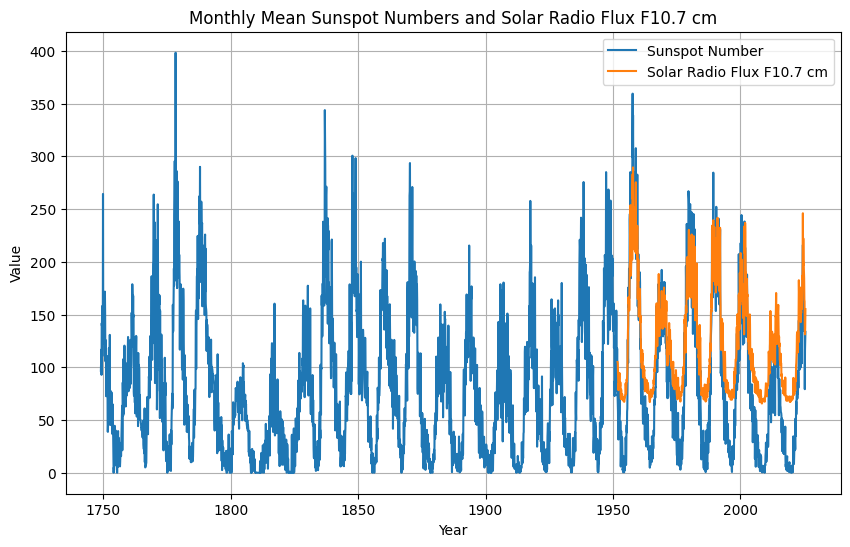

In [24]:
plt.figure(figsize=(10, 6))
time_radio = radio_year + (radio_month - 1) / 12
time_sunspot = sunspot_year + (sunspot_month - 1) / 12
plt.plot(time_sunspot, sunspot_number, label='Sunspot Number')
plt.plot(time_radio, radio_flux, label='Solar Radio Flux F10.7 cm')
plt.title('Monthly Mean Sunspot Numbers and Solar Radio Flux F10.7 cm')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
def running_mean_13(data):
    n = len(data)
    smoothed = np.zeros_like(data)
    for i in range(n):
        if i < 6:
            smoothed[i] = np.mean(data[0:i+6])
        elif i >= n - 6:
            smoothed[i] = np.mean(data[i-6:])
        else:
            left_edge = data[i-6] / 24.0
            middle_sum = np.sum(data[i-5:i+6]) / 12.0
            right_edge = data[i+6] / 24.0
            smoothed[i] = left_edge + middle_sum + right_edge
    return smoothed

radio_flux_smooth = running_mean_13(radio_flux)
sunspot_smooth = running_mean_13(sunspot_number)

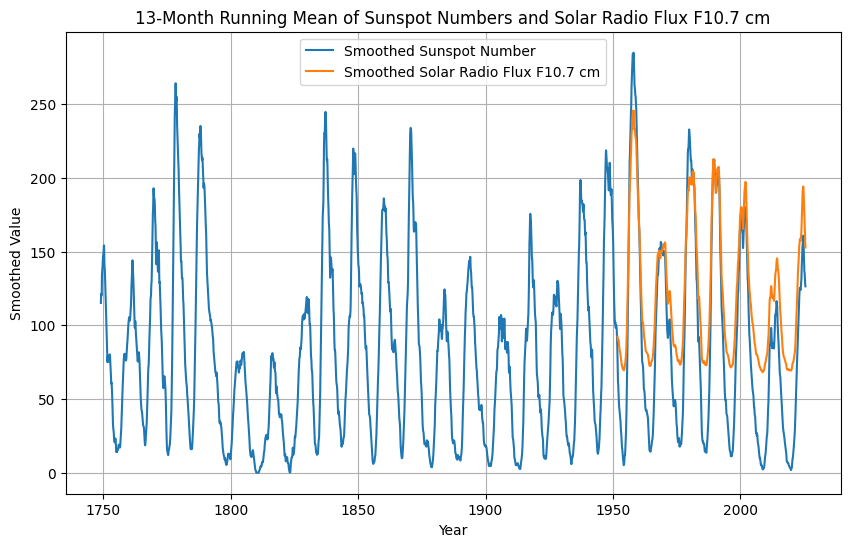

In [26]:
# Plot smoothed time series
plt.figure(figsize=(10, 6))
plt.plot(time_sunspot, sunspot_smooth, label='Smoothed Sunspot Number')
plt.plot(time_radio, radio_flux_smooth, label='Smoothed Solar Radio Flux F10.7 cm')
plt.title('13-Month Running Mean of Sunspot Numbers and Solar Radio Flux F10.7 cm')
plt.xlabel('Year')
plt.ylabel('Smoothed Value')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Find overlapping period of data for scatter plot
radio_dates = set(zip(radio_year, radio_month))
sunspot_dates = set(zip(sunspot_year, sunspot_month))
overlap_dates = sorted(list(radio_dates.intersection(sunspot_dates)))

radio_indices = [np.where((radio_year == y) & (radio_month == m))[0][0] for y, m in overlap_dates]
sunspot_indices = [np.where((sunspot_year == y) & (sunspot_month == m))[0][0] for y, m in overlap_dates]

radio_overlap = radio_flux_smooth[radio_indices]
sunspot_overlap = sunspot_smooth[sunspot_indices]

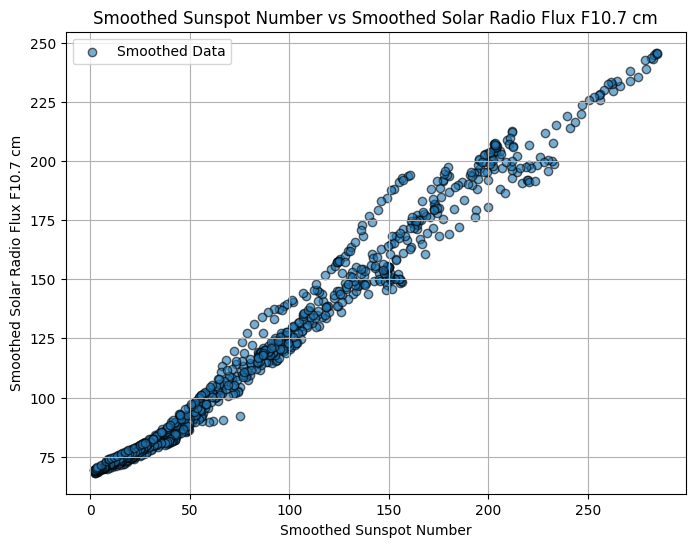

In [28]:
# Scatter plot of smoothed sunspot numbers vs solar radio flux
plt.figure(figsize=(8, 6))
plt.scatter(sunspot_overlap, radio_overlap, alpha=0.6, edgecolor='k', label='Smoothed Data')
plt.title('Smoothed Sunspot Number vs Smoothed Solar Radio Flux F10.7 cm')
plt.xlabel('Smoothed Sunspot Number')
plt.ylabel('Smoothed Solar Radio Flux F10.7 cm')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Define regressand vector F (smoothed solar radio flux)
F = radio_flux_smooth[radio_indices]

# Define regressors matrix R (with columns: 1, R, R^2, R^3 from smoothed sunspot numbers)
R_sunspot = sunspot_smooth[sunspot_indices]
R = np.column_stack((np.ones(len(R_sunspot)), 
                     R_sunspot, 
                     R_sunspot**2, 
                     R_sunspot**3))

# Calculate coefficients vector beta using Least Squares Method
# beta = (R^T R)^-1 R^T F
RtR = np.dot(R.T, R)
RtF = np.dot(R.T, F)
beta = np.linalg.inv(RtR).dot(RtF)

# Reconstruct smoothed solar radio flux using the regression model
F_reconstructed = beta[0] + beta[1]*R_sunspot + beta[2]*R_sunspot**2 + beta[3]*R_sunspot**3

# Calculate Root Mean Square Error (RMSE)
N = len(F)
rmse = np.sqrt(np.sum((F - F_reconstructed)**2) / (N - 1))

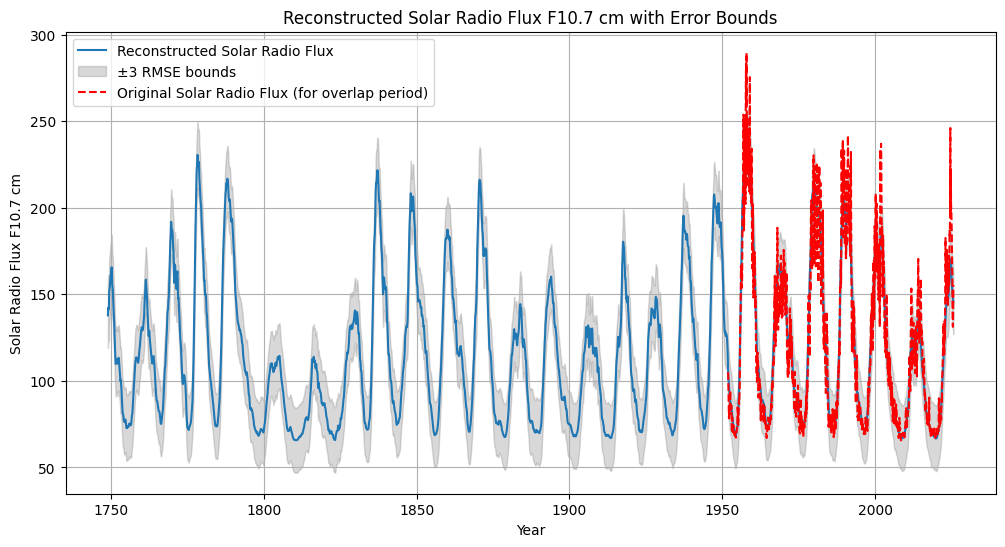

In [30]:
# Apply model backward in time where only sunspot numbers available
# Use full sunspot smoothed data for reconstruction
F_full_reconstructed = beta[0] + beta[1]*sunspot_smooth + beta[2]*sunspot_smooth**2 + beta[3]*sunspot_smooth**3

# Calculate error bounds ±3*rmse
upper_bound = F_full_reconstructed + 3*rmse
lower_bound = F_full_reconstructed - 3*rmse

# Plot reconstruction with error bounds
plt.figure(figsize=(12, 6))
full_time = sunspot_year + (sunspot_month - 1)/12
plt.plot(full_time, F_full_reconstructed, label='Reconstructed Solar Radio Flux')
plt.fill_between(full_time, lower_bound, upper_bound, color='gray', alpha=0.3, label='±3 RMSE bounds')
plt.plot(radio_year + (radio_month - 1)/12, radio_flux, 'r--', label='Original Solar Radio Flux (for overlap period)')
plt.title('Reconstructed Solar Radio Flux F10.7 cm with Error Bounds')
plt.xlabel('Year')
plt.ylabel('Solar Radio Flux F10.7 cm')
plt.legend()
plt.grid(True)
plt.show()